<a href="https://colab.research.google.com/github/babakansari/StoryPointsPrediction/blob/master/Copy_of_Ansari_Jaberi_Software_Effort_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Author name:

<pre> Babak Ansari-Jaberi</pre>
<pre> November 2018</pre>

# User Story points(weight) prediction

### Data Prepration

Load data from development tracking software and prepare it for machine learning.

The data would include the work item number, the previously predicted weight and columns of required activities (called labels) to be used for training.

In [0]:
#!pip3 install jira
!pip3 install sklearn
!pip3 install pandas
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install xlrd 
!pip3 install nltk

In [0]:
# import pandas as pd
# import http.client

# url = 'https://github.com/babakansari/StoryPointsPrediction/blob/master/Team1JiraReportMain.xlsx?raw=true'
# df1 = pd.read_excel(url, 'User Story Prediction')
# df1.head(5)

# def exists(site, path):
#  conn = http.client.HTTPConnection(site, 80)
#  conn.request('HEAD', path)
#  response = conn.getresponse()
#  conn.close()
#  return response.status == 200

# if exists('https://github.com', '/babakansari/StoryPointsPrediction/blob/master/Team1JiraReportMain.xlsx?raw=true'):
#  print('File exist')

In [0]:

import getpass
import pandas as pd
import numpy as np
import os.path
from pandas import ExcelWriter
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import http.client

#file_name = 'Team1JiraReportMain.xlsx'
file_name = 'https://github.com/babakansari/StoryPointsPrediction/blob/master/Team1JiraReportMain.xlsx?raw=true'
sheetname = 'User Story Prediction'
#jiraFileExist = os.path.exists(file_name)

#if not jiraFileExist:
#    from jira import JIRA
#    #input( "Username: ")
#    userName = 'user1@company.com' 
#    password = getpass.getpass(prompt='Username: '+userName+'\r\nPassword: ')

#    auth_jira = JIRA(server = 'https://company.atlassian.net', auth=( userName, password ))

    # my top 5 issues due by the end of the week, ordered by priority
#    oh_crap = auth_jira.search_issues('"Tech Team"="Team 1" AND Sprint is not EMPTY AND "Story Points" is not EMPTY and labels is not EMPTY order by priority desc', maxResults=1000)


In [0]:
# Read data source to create data frame of the labels
# Insert labels into data frame
#if not jiraFileExist:
#    print("Reading from Jira...")
#    pd.options.mode.chained_assignment = None  # default='warn'
#    labels_df = pd.DataFrame(columns=['Labels'])
#    story_df = pd.DataFrame(columns=['Index', 'Key', 'Summary', 'Points', 'Labels'])
#    
#    i = 0
#    r = 0
#    for issue in oh_crap:
#        hasMlTag = False
#        for label in issue.fields.labels:
#            if 'ML-' in label:
#                labels_df.loc[i] = [label]
#                hasMlTag = True
#            i = i + 1
#        if hasMlTag:
#            story_df.loc[i] = [r, issue.key, issue.fields.summary, issue.fields.customfield_10049, None]
#            story_df.at[i, 'Labels'] = issue.fields.labels
#            r = r+1

#    print("Number of records read: ",r)
#    labels_df = labels_df.drop_duplicates()
#    labels_df = labels_df.set_index('Labels').T
    
#    combine_df = pd.concat([story_df, labels_df], ignore_index=False)
    
#    for index, row in combine_df.iterrows():
#        #print( row['Key'], row['Points'] )
#        for label in row['Labels']:
#            if label in labels_df.columns:
#                combine_df.loc[index, label] = 1

#    df = combine_df.drop(columns=['Labels'])
#    df.fillna(0, inplace=True)
#    writer = ExcelWriter(file_name)
#    df.to_excel(writer,sheetname)
#    writer.save()
#else:
    print("Data loaded from file:",file_name)
    df = pd.read_excel(file_name, sheetname)

Data loaded from file: https://github.com/babakansari/StoryPointsPrediction/blob/master/Team1JiraReportMain.xlsx?raw=true


In [0]:
df.shape

(92, 18)

### Training 

Divide data into 70% for training and 40% for testing:

In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.4, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

55 train + 37 test


Identify target column and feature variables:

In [0]:
target = 'Points'
features = list(train_set.columns)
features = [f for f in features if f!=target and f!='Index' and f!='Key' and f!='Summary']

# Split data into train and test sets
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

In [0]:
# Encode points using one hot encoder
from sklearn.preprocessing import OneHotEncoder

points_tr = train_set[[target]]

cat_encoder = OneHotEncoder(sparse=False)

points_tr_fit = cat_encoder.fit(points_tr)

points_tr_cat = points_tr_fit.transform(points_tr)

points_te = test_set[[target]]
points_te_cat = cat_encoder.fit_transform(points_te)

points_te_cat
y_tr = points_tr_cat
y_te = points_te_cat


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

Define training model liberaries and a function for finding best parameters for a model using for Grid Search:

In [0]:
import pandas
import warnings
warnings.filterwarnings('ignore')
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from nltk.classify.scikitlearn import SklearnClassifier

pd.options.mode.chained_assignment = None 

def SearchBestParameters(model, parameters):
    y = df[[target]]
    yy = label_binarize(y, classes=[0, 1, 2 , 3, 4])
    n_classes = yy.shape[1]
    classifier = OneVsRestClassifier(model)

    gs = GridSearchCV(classifier, parameters, cv=3, scoring='r2') # Using R^2 (coefficient of determination)
    gs.fit(X_tr, y_tr).decision_function(X_te)    
    
    #print(classifier.get_params().keys())
    model_params = {}
    for param in gs.best_params_:
        model_param = param.replace("estimator__", "")
        model_params[model_param] = gs.best_params_[param]
    print(type(model).__name__, ': ', model_params, 'with score:', gs.best_score_)
    return model_params

Using Grid Search to find the best parameters for `Logistic Regression` classifier:

In [0]:
grid = {
    'estimator__C': [0.01, 1, 5, 7],
    'estimator__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'estimator__multi_class': ['ovr', 'multinomial']
}
logistic = LogisticRegression()
best_params = SearchBestParameters(logistic, grid)
logistic = LogisticRegression(**best_params)   
    

LogisticRegression :  {'C': 0.01, 'multi_class': 'ovr', 'solver': 'sag'} with score: -0.22312780653689734


Using Grid Search to find the best parameters for `SVC` classifier:

In [0]:
grid={
    'estimator__C': [3, 5, 7],
    'estimator__kernel': [ 'linear', 'poly', 'rbf']
}
svc = SVC(probability=True)
best_params = SearchBestParameters(svc, grid)
svc = SVC(probability=True, **best_params)

SVC :  {'C': 5, 'kernel': 'rbf'} with score: -0.5512649824922551


In [0]:
grid={
    'estimator__C': [3, 5, 7],
    'estimator__multi_class': ['ovr', 'crammer_singer'], 
}
linearSVC = LinearSVC()
best_params = SearchBestParameters(linearSVC, grid)
linearSVC = LinearSVC(**best_params)

LinearSVC :  {'C': 7, 'multi_class': 'crammer_singer'} with score: -1.056783620419984


Add all models to ensemble and one of good one to Ada Boost classifier:

In [0]:
# create the sub models

#logistic = LogisticRegression(C=5, solver='newton-cg',multi_class='multinomial')
#svc = SVC(C=0.1, gamma=1, kernel='poly', probability=True) 
#linearSVC = LinearSVC(C=2, multi_class='crammer_singer', tol= 1000.0)

#randomForest = RandomForestClassifier(criterion='entropy', max_depth=7, max_features='auto', n_estimators=10)

adaBoost = AdaBoostClassifier(logistic)  

Create `score_model` function to draw the classifiers performance:

In [0]:
def one_hot_decode(coded):         
    decoded = coded.dot(cat_encoder.active_features_).astype(int)
    return decoded

def display_scores(scores):
    print("\033[1mCross Validation Score:\033[0m \n\t{} (+/- {})".format(round(scores.mean(),2), round(scores.std(),2)))


In [0]:
def F(n):
    if n == 0: return 0
    elif n == 1: return 1
    else: return F(n-1)+F(n-2)
    
def score_model(model): 
    print('<< \033[1m', type(model).__name__, '\033[0m>>')
    # Binarize the output
    y = df[[target]]
    yy = label_binarize(y, classes=[0, 1, 2 , 3, 4])
    n_classes = yy.shape[1]

    classifier = OneVsRestClassifier(model)
    
    y_score = classifier.fit(X_tr, y_tr).decision_function(X_te) 
    # plot the roc curve
    if hasattr(model, 'predict_proba'):
        # Binarize the output
        lw=2
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_score[:, i], pos_label=1)
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_te.ravel(), y_score.ravel(), pos_label=1)
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=(8, 6))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'red', 'green'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(F(i+2), roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.grid()
        plt.xticks(np.arange(0,1.1,0.1))
        plt.yticks(np.arange(0,1.1,0.1))
        plt.show()

    # Test vs prediction scatter plot
    y_score_c = classifier.predict(X_te)

    decoded_y_te = one_hot_decode(y_te)
    decoded_y_score_c = one_hot_decode(y_score_c)

    # Prediction Score
    print('\033[1mEstimator Score:\033[0m\n\tTraining: ', round(classifier.score(X_tr, y_tr), 2), 
            '\n\tTest : ', round(classifier.score(X_te, y_te),2))

    scores = cross_val_score(classifier, X_tr, y_tr,scoring="accuracy", cv=4)

    display_scores(scores)
    print('_______________________________________________________________________')

Using `score_model` to plot the models accuracy:

<<  LogisticRegression >>


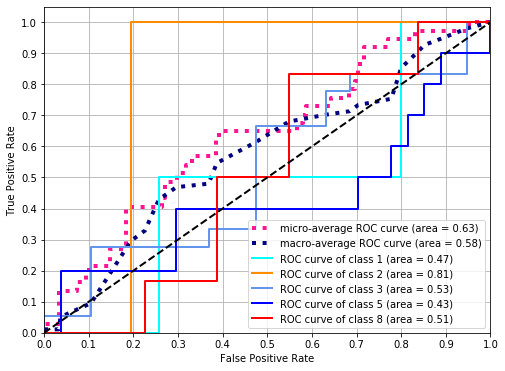

Estimator Score:
	Training:  0.0 
	Test :  0.0
Cross Validation Score: 
	0.0 (+/- 0.0)
_______________________________________________________________________
<<  SVC >>


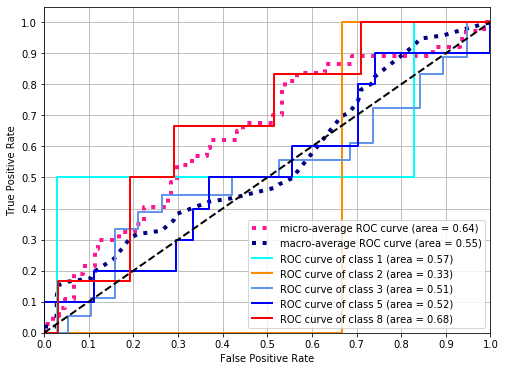

Estimator Score:
	Training:  1.0 
	Test :  0.22
Cross Validation Score: 
	0.2 (+/- 0.09)
_______________________________________________________________________
<<  AdaBoostClassifier >>


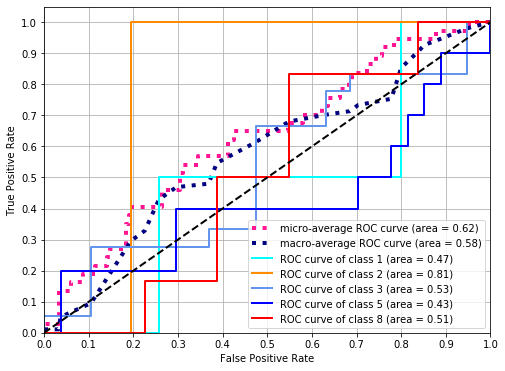

Estimator Score:
	Training:  0.0 
	Test :  0.0
Cross Validation Score: 
	0.0 (+/- 0.0)
_______________________________________________________________________
<<  LinearSVC >>
Estimator Score:
	Training:  0.45 
	Test :  0.19
Cross Validation Score: 
	0.15 (+/- 0.14)
_______________________________________________________________________


In [0]:
score_model(logistic)
score_model(svc)
score_model(adaBoost)
score_model(linearSVC)

### Prediction

Get the User Story number and predict its size base on the given `Labels`:

In [0]:
prediction_df = df.copy()
prediction_df = prediction_df.drop(columns=['Index', 'Key', 'Points', 'Summary']).iloc[0:0]
prediction_df.shape

In [0]:
userName = 'user1@company.com' 
password = getpass.getpass(prompt='Username: '+userName+'\r\nPassword: ')

auth_jira = JIRA(server = 'https://company.atlassian.net', auth=( userName, password ))

story = input( "User Story # ILX-")
#story = '8397' 3pts
#story = '10559' 2pts
#story = '9885' 8pts

issue = auth_jira.issue('ILX-'+story)
print('Predicting points for \033[1m\033[94m`',issue.fields.summary ,'`\033[0m User Story.')

Prepare the input data for prediction:

In [0]:
for column in prediction_df.columns:
    prediction_df.loc[0, column] = 0
    for label in issue.fields.labels:
        prediction_df.loc[0, label] = 1

print('Manual prediction was:\033[1m\033[94m', issue.fields.customfield_10049,'\033[0m')


Create predict points function to use various models for prediction:

In [0]:
import operator

def predict_points(model, input_df): 
    classifier = OneVsRestClassifier(model)
    classifier.fit(X_tr, y_tr)
    predict = classifier.predict(prediction_df)
    if hasattr(model, 'predict_proba'):
        predict_prop = classifier.predict_proba(prediction_df)
        prediction = one_hot_decode(predict[0])
        index, value = max(enumerate(predict_prop[0]), key=operator.itemgetter(1))
        print('\033[1m',type(model).__name__, '\033[0mprediction is\033[1m\033[94m', 
            F(index+2), '\033[0mpoints with\033[1m\033[94m', round(value,2)*100,'%\033[0m probability')
    else:
        prediction = one_hot_decode(predict[0])
        print('\033[1m',type(model).__name__, '\033[0mprediction is\033[1m\033[94m', 
            prediction, '\033[0mpoints')


Predict using various prediction models:

In [0]:
predict_points(logistic, prediction_df)
predict_points(svc, prediction_df)
predict_points(linearSVC, prediction_df)
predict_points(adaBoost, prediction_df)


### Conclusion

 - VotingClassifier, GaussianNB and SVC seems to perform very well
 - The data is not well defined and dimension could be reduced
 - There could be weightage for each Label to make prediction more accurate
 - Not enough data defined